# Audio Emotion Classification:
in this project we will conceptualize and code a model that classifies Audio signals into 3 possible emotions.  
## Libraries

In [147]:
import torch
import torch.nn as nn
import os
import numpy as np
import librosa
import random
import math
import matplotlib.pyplot as plt
import json
from torch.nn.functional import relu as ReLU

## Preprocessing
get, extract words and normalize (amplitude and time)

In [197]:
def load_wavs(directory):
    wavs = []
    filenames = os.listdir(directory)
    for filename in filenames[0:30]:
        _, _, _, _, emotion, _ = filename.replace(".wav", "").split("-")
        y, sr = librosa.load(os.path.join(directory, filename))
        wavs.append((y, int(emotion)))
    return wavs

def load_noise(directory):
    noise = []
    filenames = os.listdir(directory)
    for filename in filenames[0:30]:
        y, sr = librosa.load(os.path.join(directory, filename))
        noise.append((y, 3))
    return noise

def random_pad(signal, padding):
    point = math.floor(random.random()*padding)
    return np.concatenate((np.zeros(point), signal, np.zeros(padding - point)))
    
def normalize_time(signals):
    padded_signals = []
    max_length = max([len(signal) for signal in signals])
    for signal in signals: padded_signals.append(random_pad(signal, max_length - len(signal)))
    return padded_signals

def normalize_amplitude(signal):
    normalized_signal = (signal - np.mean(signal))/np.std(signal)
    return normalized_signal

## Features Extraction
extracting:  
- 40 Mel-frequency cepstral coefficients (MFCC)
- 128 Mel spectrogram
- 12 chromagram
- Other 6 features (RMS energy, energy, zero crossing
rate (ZCR), spectral centroid, spectral flux, and
spectral rolloff)

In [198]:
def extract_features(y, sr):
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 40 MFCCs
    mfcc = mfcc.flatten()  # Flatten MFCC
    
    # Extract Mel spectrogram
    # mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)  # 128 Mel bins
    # mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibel scale
    # mel_spec = mel_spec.flatten()  # Flatten Mel spectrogram

    # # Extract chromagram
    # chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12)  # 12 chroma bins
    # chroma = chroma.flatten()  # Flatten chromagram

    # # Extract other features
    # rms = librosa.feature.rms(y=y)  # RMS energy
    # rms = rms.flatten()  # Flatten RMS

    # energy = np.sum(y ** 2) / np.float64(len(y))  # Energy
    # zero_crossing_rate = librosa.feature.zero_crossing_rate(y)  # Zero crossing rate
    # zero_crossing_rate = zero_crossing_rate.flatten()  # Flatten zero crossing rate
    # spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # Spectral centroid
    # spectral_centroid = spectral_centroid.flatten()  # Flatten spectral centroid
    # spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)  # Spectral flux
    # spectral_flux = spectral_flux.flatten()  # Flatten spectral flux
    # spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)  # Spectral rolloff
    # spectral_rolloff = spectral_rolloff.flatten()  # Flatten spectral rolloff

    # Combine all features
    features = mfcc.tolist()

    return features

## Convolutional Neural Network architecture
<img src="CNN_Architecture.png" width="500">

In [202]:
class Model(nn.Module):
    def __init__(self, feature_count):
        super().__init__()
        # convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(512)
        self.conv3 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(256)
        self.conv5 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flattening_count = feature_count
        for i in range(5): self.flattening_count = math.floor(self.flattening_count/2)
            
        # fully connected layers
        self.fc1 = nn.Linear(128*self.flattening_count, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 4)
        
    def forward(self, x):
        # convolutional layers
        x = self.pool(self.bn1(torch.relu(self.conv1(x))))
        x = self.pool(self.bn1(torch.relu(self.conv2(x))))
        x = self.pool(self.bn2(torch.relu(self.conv3(x))))
        x = self.pool(self.bn2(torch.relu(self.conv4(x))))
        x = self.pool(self.bn3(torch.relu(self.conv5(x))))
        
        # fully connected layers
        x = x.view(-1, 128 * self.flattening_count)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation function for the output layer
        
        return x
        
    def train(self, x, y, critereon, optimizer, epoch):
        losses = []
        for e in range(epoch):
            y_pred = self.forward(x)
            loss = critereon(y_pred, y)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return losses

## creating data

In [203]:
wavs = load_wavs("wavs")
noise = load_noise("noise")
signals = normalize_time([wav[0] for wav in wavs] + [n[0] for n in noise])
x = [extract_features(signal, 22050) for signal in signals]
y = [wav[1] for wav in wavs] + [n[1] for n in noise]
with open("data.json", "w") as fp:
    json.dump({"x": x, "y": y}, fp, indent = 4)


## putting everything together

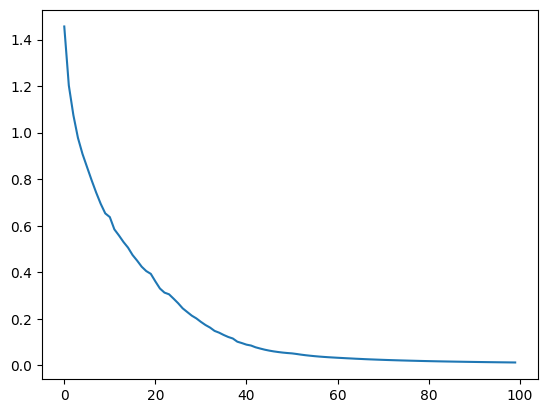

In [204]:
## loading the data
with open("data.json", "r") as fp:
    data = json.load(fp)
x = data["x"]
y = data["y"]

x = torch.FloatTensor(data["x"]).unsqueeze(1)
y = torch.LongTensor(data["y"])
## splitting the data

## creating the model
model = Model(len(x[0][0]))

## specifying loss function and optimization method
critereon = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## training the model
losses = model.train(x, y, critereon, optimizer, 100)

## displaying results
display_losses(losses)